In [1]:
# =========================================================================== #
# Date: 02/21/20
# Author: Esther Song
# Description:
# Generate a mood metric, which assigns each message to one of eight emotion categories
#   in depechemood (inspired, amused, sad ... )
# =========================================================================== #

# import datetime
import importlib
import logging
import pandas as pd
import pickle
import spacy
import sys
import re
import numpy as np

# from tqdm import tqdm
import en_core_web_lg


# =========================================================================== #
# SET UP LOGGING
# =========================================================================== #

logging.basicConfig(filename="logs/build_mood_metric.log",
                    filemode="a",
                    level=logging.INFO,
                    format="%(asctime)s - %(message)s",
                    datefmt="%d-%b-%y %H:%M:%S")

logging.info("Starting mood metric building script...")

# =========================================================================== #
# LOAD MODULES AND MODELS
# =========================================================================== #

# read_data = importlib.import_module(".read_data", package="src")
# clean_text = importlib.import_module(".clean_text", package="src")

from read_data import *
from clean_text import *

nlp = spacy.load("en_core_web_lg")

logging.info("Finished loading modules and models...")

# =========================================================================== #
# HELPER FUNCTIONS
# =========================================================================== #

def full_clean_text(text):
    """Combined clean text functions to fully clean text
    Args
        text: [string] message text
    Returns
        cleaned_text: [string] message text cleaned
    """
    cleaned_text = ''
    if type(text)!= float:
        clean_text0 = clean_urls(text)
        clean_text1 = remove_at_mentions(clean_text0)
        clean_text2 = remove_code_markup(clean_text1)
        clean_text3 = remove_emoticons(clean_text2)
        clean_text4 = format_text(clean_text3)
        # Remove new line characters
        clean_text5 = re.sub(r"(?<=[a-z])\r?\n"," ", clean_text4)
        # remove special characters
        clean_text6 = re.sub('[^A-Za-z0-9]+', ' ', clean_text5)
        # remove digits
        clean_text7 = re.sub(r'[0-9]+', '', clean_text6)
        cleaned_text = clean_text7
    return cleaned_text

nlp = spacy.load('en_core_web_lg')

def tokenize_func(text):
    doc = nlp(text)
    first_words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    words = [w for w in first_words if len(w) > 2]
    words = [w for w in words if w != 'http'] # remove http
    return words

# =========================================================================== #
# LOAD THE DATA
# =========================================================================== #

filename = "SharedConversations.json"
data_df = read_json_data(filename)
# drop empty messages
data_df = data_df.dropna(subset = ['text']).reset_index(drop = True)
data_df = data_df[data_df['text'].apply(len) > 0].reset_index(drop=True)

logging.info("Read data...")

In [2]:
total = data_df.copy()
total.shape

(35832, 19)

In [3]:
#============================================================================ #
# Create Timestamps
#============================================================================ #
total['userTimestamp'] = pd.to_datetime(total['userTimestamp'],format='%Y-%m-%d %H:%M:%S')
total.dtypes

uniqueMessageChannelId            object
companyId                         object
teamId                            object
userId                            object
text                              object
userChannelId                     object
channelId                         object
channelTs                         object
timestamp                         object
userTimestamp             datetime64[ns]
rawScore                          object
rawMagnitudeScore                 object
isWeekend                         object
isOutOfWorkingHours               object
numPositiveEmojis                 object
numNegativeEmojis                 object
hasQuestionMark                   object
channelThreadTs                   object
numSharedFiles                    object
dtype: object

In [4]:
total_2018_q1 = total[(total['userTimestamp'].dt.year == 2018) & (total['userTimestamp'].dt.month < 4)]
total_2018_q1.shape

(5199, 19)

In [5]:
total_2018_q1['userTimestamp'].dt.month.unique() # 2018 - first quarter

array([3, 2, 1])

In [6]:
#============================================================================ #
# Clean text
#============================================================================ #
total_2018_q1["cleanText"] = total_2018_q1["text"].apply(full_clean_text)
# remove empty text
total_2018_q1 = total_2018_q1[total_2018_q1['cleanText'].apply(len) > 0].reset_index(drop=True)

#============================================================================ #
# Tokenize
#============================================================================ #
total_2018_q1['tokens'] = total_2018_q1['cleanText'].apply(tokenize_func)
# remove when the tokens column is empty
total_2018_q1 = total_2018_q1[total_2018_q1['tokens'].apply(len) > 0].reset_index(drop=True) # drop empty token rows

/Users/esthersong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
total_2018_q1.shape

(4856, 21)

In [8]:
5199 - 4856  # 343 rows removed, which were empty

343

In [9]:
#============================================================================ #
# Read Depechemood
#============================================================================ #

def read_depechemood():
    '''
    Reads depechemood lexicon that has scores for 8 ranges of mood for 37 terms

    Returns
    -------
    A panda dataframe with terms as index, emotion categories as columns, scores as rows
    '''
    dm_url = "https://raw.githubusercontent.com/marcoguerini/DepecheMood/master/DepecheMood%2B%2B/DepecheMood_english_token_full.tsv"
    depechemood = pd.read_csv(dm_url, sep='\t', index_col=0)
    depechemood = depechemood[depechemood['freq']> 10]
    depechemood.drop('freq', inplace=True, axis=1)
    return depechemood

def extract_emofeats(lex, lex_vocab, tokenized):
    '''
    Finds words in the text that matches with the lexicon
    Extracts emotion scores

    Returns
    -------

    A word-emotion matrix for a given text

    '''
    # return emotion word matrix
    lex_dict = lex.to_dict('split')
    lex_d = {word: lex_dict['data'][i] for i, word in enumerate(lex_dict['index'])}
    assert len(lex_d.keys()) == len(lex_vocab)
    Ss = np.zeros((len(tokenized), lex.shape[1]))
    for i, doc in enumerate(tokenized):
        intersection = set(lex_vocab) & set([doc])
        s = []
        for inter in intersection:
            s.append(lex_d[inter])
        s = np.array(s)
        divisor = len(s) if len(s) > 0 else 1
        Ss[i, :] = np.sum(s, axis=0) / divisor
    return Ss

dm = read_depechemood()

def mood_metric_scores(tokenized):
    '''
    Obtains the emotion class based on the maximum score obtained from emofeats

    Returns
    -------
    Emotion class and the emotion score vector
    '''
    Ss = extract_emofeats(dm, set(dm.index.values), tokenized)
    # average the emoscore for each emotion category
    k = np.array([sum(Ss[:,i]) for i in range(Ss.shape[1])])/Ss.shape[1]
    # normalize the row vector
    # this is the score range
    if k.sum(axis=0,keepdims=1) == 0:
        n = len(k)
        q = [0] * n
    else:
        q = k/k.sum(axis=0,keepdims=1) # message-level emo-score;
    # get the classified emotion
    p = list(q)
    emo_name = []
    for col in dm.columns:
        emo_name.append(col)
    # get the class
    # if the sum of the list is 0 meaning there are no matched -- label 'unclassified'
    if sum(p) == 0:
        emo_class = 'unclassified'
    else:
        m = max(p)
        pos = p.index(m)
        emo_class = emo_name[pos].lower()
    return emo_class

### Test on a Sample, 100 Messages

In [10]:
# test on some of the messages
sample = total_2018_q1[900:910]

In [11]:
# progress_map
from tqdm import tqdm
tqdm.pandas() 

/Users/esthersong/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
# time how long it takes to label 5K messages
import time
t0 = time.time()
sample['dm_label'] = sample['tokens'].progress_map(mood_metric_scores)
# sample['dm_label'] = sample['tokens'].apply(mood_metric_scores)
t1 = time.time()

# time took
total = t1-t0
print('Total time took to label 100 messages is '+str(total)+' seconds')

100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

Total time took to label 100 messages is 3.286406993865967 seconds



/Users/esthersong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
sample[sample['dm_label'] == 'unclassified'].shape
# 0 messages 

(0, 22)

In [14]:
# see the emo_feats
sample['text'][sample['dm_label'] == 'inspired']

900                   so it's easy to "get started fast"
906        and i think it does a pretty good job of that
907    at the same time, the diea is to keep it as si...
909                           that's the point, actually
Name: text, dtype: object

### Total 4856 Messages

In [15]:
t0 = time.time()
total_2018_q1['dm_label'] = total_2018_q1['tokens'].progress_map(mood_metric_scores)
# sample['dm_label'] = sample['tokens'].apply(mood_metric_scores)
t1 = time.time()

# time took
total = t1-t0
print('Total time took to label 4856 messages is '+str(total)+' seconds')

100%|██████████| 4856/4856 [28:10<00:00,  2.87it/s]

Total time took to label 4856 messages is 1690.7349631786346 seconds


In [33]:
total_2018_q1[total_2018_q1['dm_label'] == 'unclassified'].shape

(164, 22)

In [81]:
# use counter
m = list(total_2018_q1['dm_label'])
from collections import Counter
m_dict = dict(Counter(m))
print(m_dict,m_dict.keys(),m_dict.values()) # see if the order match

{'inspired': 2418, 'amused': 1150, 'annoyed': 440, 'sad': 30, 'afraid': 138, 'angry': 302, 'happy': 57, 'dont_care': 157, 'unclassified': 164} dict_keys(['inspired', 'amused', 'annoyed', 'sad', 'afraid', 'angry', 'happy', 'dont_care', 'unclassified']) dict_values([2418, 1150, 440, 30, 138, 302, 57, 157, 164])


In [82]:
df = pd.DataFrame.from_dict(m_dict,orient='index')
df

,0
inspired,2418
amused,1150
annoyed,440
sad,30
afraid,138
angry,302
happy,57
dont_care,157
unclassified,164


In [83]:
# rename columns
df.rename(columns = {0:'message_counts'}, inplace = True) 
df['emotion'] = df.index.to_series()
df['per'] = round(df['message_counts']/(df['message_counts'].sum()),2) * 100
df

,message_counts,emotion,per
inspired,2418,inspired,50.0
amused,1150,amused,24.0
annoyed,440,annoyed,9.0
sad,30,sad,1.0
afraid,138,afraid,3.0
angry,302,angry,6.0
happy,57,happy,1.0
dont_care,157,dont_care,3.0
unclassified,164,unclassified,3.0


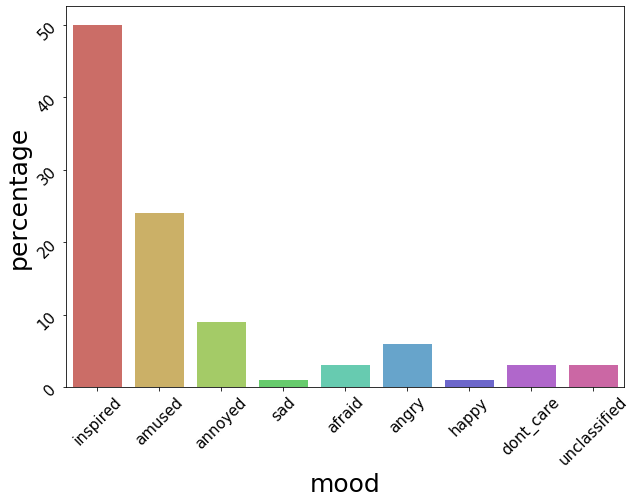

In [84]:
# plot proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plot the scores
plt.figure(figsize=(10,7))
ax = sns.barplot(x='emotion', y='per', data=df, palette="hls")
ax.set_xlabel('mood', fontsize = 25)
ax.set_ylabel('percentage', fontsize = 25)
ax.tick_params(axis="x", labelsize=15, labelrotation=45)
ax.tick_params(axis="y", labelsize=15, labelrotation=45)
plt.show()

In [89]:
# removing unclassified
4856 - 164

4692

## Different Threshold -- If Max Emotion Score is Less than 0.2, Label it Unclassified

Taking into account some of the comments I received during the demo, I revised the metric so that it only label the  message when the score is larger than 0.2. I chose 0.2 because the example words the authors show in the paper that maps onto the emotion category had scores above 0.2. For example, the word 'funny' had a score above 0.29; word 'kill' had scores 0.23 and 0.21 respectively, for categories afraid and anger. Given these examples, I lable messages with the maximum score below 0.2 as 'unclassified'.

In [26]:
# try with sample
# redefine mood_metric_score function:


def mood_metric_scores2(tokenized):
    '''
    Obtains the emotion class based on the maximum score obtained from emofeats

    Returns
    -------
    Emotion class and the emotion score vector
    '''
    Ss = extract_emofeats(dm, set(dm.index.values), tokenized)
    # average the emoscore for each emotion category
    k = np.array([sum(Ss[:,i]) for i in range(Ss.shape[1])])/Ss.shape[1]
    # normalize the row vector
    # this is the score range
    if k.sum(axis=0,keepdims=1) == 0:
        n = len(k)
        q = [0] * n
    else:
        q = k/k.sum(axis=0,keepdims=1) # message-level emo-score;
    # get the classified emotion
    p = list(q)
    emo_name = []
    for col in dm.columns:
        emo_name.append(col)
    # get the class
    # if the sum of the list is 0 meaning there are no matched -- label 'unclassified'
    if sum(p) == 0:
        emo_class = 'unclassified'
    else:
        pass
    # threshold -- 0.2
    m = max(p)
    if m < 0.2:
        emo_class = 'unclassified'
    else:
        pos = p.index(m)
        emo_class = emo_name[pos].lower()
    return emo_class

In [27]:
import time
t0 = time.time()
sample['dm_label'] = sample['tokens'].progress_map(mood_metric_scores2)
# sample['dm_label'] = sample['tokens'].apply(mood_metric_scores)
t1 = time.time()

# time took
total = t1-t0
print('Total time took to label 100 messages is '+str(total)+' seconds')

100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

Total time took to label 100 messages is 3.3633389472961426 seconds



/Users/esthersong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
sample[sample['dm_label'] == 'unclassified'].shape
# 0 messages 

(1, 22)

In [29]:
sample['text'][sample['dm_label'] == 'unclassified']

905    devops is just a very large domain
Name: text, dtype: object

## Re-Run on 5K Message and See Difference

In [39]:
total_2018_q1_v3 = total_2018_q1.copy()

In [40]:
total_2018_q1_v3.dtypes

uniqueMessageChannelId            object
companyId                         object
teamId                            object
userId                            object
text                              object
userChannelId                     object
channelId                         object
channelTs                         object
timestamp                         object
userTimestamp             datetime64[ns]
rawScore                          object
rawMagnitudeScore                 object
isWeekend                         object
isOutOfWorkingHours               object
numPositiveEmojis                 object
numNegativeEmojis                 object
hasQuestionMark                   object
channelThreadTs                   object
numSharedFiles                    object
cleanText                         object
tokens                            object
dm_label                          object
dtype: object

In [42]:
from tqdm.auto import tqdm
tqdm.pandas()


import time
t0 = time.time()
total_2018_q1_v3['dm_label2'] = total_2018_q1_v3['tokens'].progress_map(mood_metric_scores2)
t1 = time.time()

# time took
total = t1-t0
print('Total time took to label 4856 messages is '+str(total)+' seconds')

/Users/esthersong/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



Total time took to label 4856 messages is 1802.0994110107422 seconds


In [79]:
a = total_2018_q1_v3[total_2018_q1_v3['dm_label'] == 'unclassified'].shape[0]
b = total_2018_q1_v3[total_2018_q1_v3['dm_label2'] == 'unclassified'].shape[0]


n = total_2018_q1_v3.shape[0]


round((a/n),2)*100
print('The proportion of unclassified messages out of total without threshold is '+ str(round((a/n),2)*100) +'%')
print('The proportion of unclassified messages out of total with threshold < 0.2 is '+str(round((b/n),2)*100) +'%')

The proportion of unclassified messages out of total without threshold is 3.0%
The proportion of unclassified messages out of total with threshold < 0.2 is 68.0%


In [85]:
# create df of labels and proportions

# use counter
m = list(total_2018_q1_v3['dm_label2'])
from collections import Counter
m_dict = dict(Counter(m))
# print(m_dict,m_dict.keys(),m_dict.values()) # see if the order match

df = pd.DataFrame.from_dict(m_dict,orient='index')

# rename columns
df.rename(columns = {0:'message_counts'}, inplace = True) 
df['emotion'] = df.index.to_series()
df['per'] = round(df['message_counts']/(df['message_counts'].sum()),2) * 100

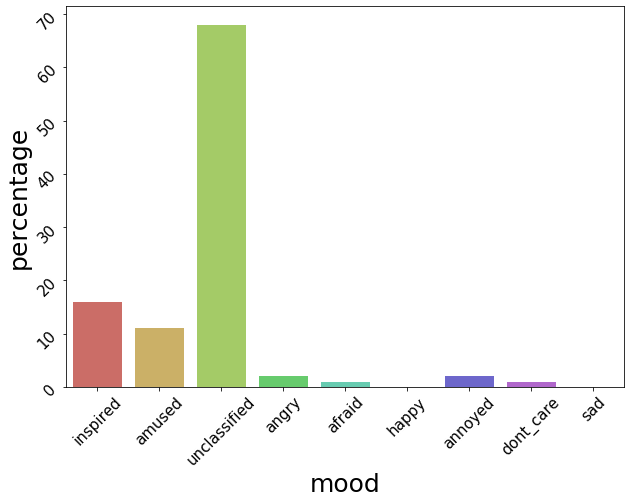

In [86]:
# plot proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plot the scores
plt.figure(figsize=(10,7))
ax = sns.barplot(x='emotion', y='per', data=df, palette="hls")
ax.set_xlabel('mood', fontsize = 25)
ax.set_ylabel('percentage', fontsize = 25)
ax.tick_params(axis="x", labelsize=15, labelrotation=45)
ax.tick_params(axis="y", labelsize=15, labelrotation=45)
plt.show()

## Threshold 0.2 throws out too many messages -- change threshold to <0.15

In [63]:
# try with sample
# redefine mood_metric_score function:


def mood_metric_scores3(tokenized):
    '''
    Obtains the emotion class based on the maximum score obtained from emofeats

    Returns
    -------
    Emotion class and the emotion score vector
    '''
    Ss = extract_emofeats(dm, set(dm.index.values), tokenized)
    # average the emoscore for each emotion category
    k = np.array([sum(Ss[:,i]) for i in range(Ss.shape[1])])/Ss.shape[1]
    # normalize the row vector
    # this is the score range
    if k.sum(axis=0,keepdims=1) == 0:
        n = len(k)
        q = [0] * n
    else:
        q = k/k.sum(axis=0,keepdims=1) # message-level emo-score;
    # get the classified emotion
    p = list(q)
    emo_name = []
    for col in dm.columns:
        emo_name.append(col)
    # get the class
    # if the sum of the list is 0 meaning there are no matched -- label 'unclassified'
    if sum(p) == 0:
        emo_class = 'unclassified'
    else:
        pass
    # threshold -- 0.15
    m = max(p)
    if m < 0.15:
        emo_class = 'unclassified'
    else:
        pos = p.index(m)
        emo_class = emo_name[pos].lower()
    return emo_class

In [64]:
import time
t0 = time.time()
total_2018_q1_v3['dm_label3'] = total_2018_q1_v3['tokens'].progress_map(mood_metric_scores3)
t1 = time.time()

# time took
total = t1-t0
print('Total time took to label 4856 messages is '+str(total)+' seconds')


Total time took to label 4856 messages is 1694.8740808963776 seconds


In [80]:
a = total_2018_q1_v3[total_2018_q1_v3['dm_label'] == 'unclassified'].shape[0]
b = total_2018_q1_v3[total_2018_q1_v3['dm_label2'] == 'unclassified'].shape[0]
c = total_2018_q1_v3[total_2018_q1_v3['dm_label3'] == 'unclassified'].shape[0]



n = total_2018_q1_v3.shape[0]


print('The proportion of unclassified messages out of total without threshold is '+str(round((a/n),2)*100) +'%')
print('The proportion of unclassified messages out of total with threshold < 0.2 is '+str(round((b/n),2)*100) +'%')
print('The proportion of unclassified messages out of total with threshold < 0.1 is '+str(round((c/n),2)*100) +'%')

The proportion of unclassified messages out of total without threshold is 3.0%
The proportion of unclassified messages out of total with threshold < 0.2 is 68.0%
The proportion of unclassified messages out of total with threshold < 0.1 is 6.0%


In [87]:
# create df of labels and proportions

# use counter
m = list(total_2018_q1_v3['dm_label3'])
from collections import Counter
m_dict = dict(Counter(m))
# print(m_dict,m_dict.keys(),m_dict.values()) # see if the order match

df = pd.DataFrame.from_dict(m_dict,orient='index')

# rename columns
df.rename(columns = {0:'message_counts'}, inplace = True) 
df['emotion'] = df.index.to_series()
df['per'] = round(df['message_counts']/(df['message_counts'].sum()),2) * 100
df

,message_counts,emotion,per
inspired,2371,inspired,49.0
amused,1130,amused,23.0
annoyed,404,annoyed,8.0
unclassified,315,unclassified,6.0
afraid,124,afraid,3.0
angry,287,angry,6.0
happy,54,happy,1.0
dont_care,146,dont_care,3.0
sad,25,sad,1.0


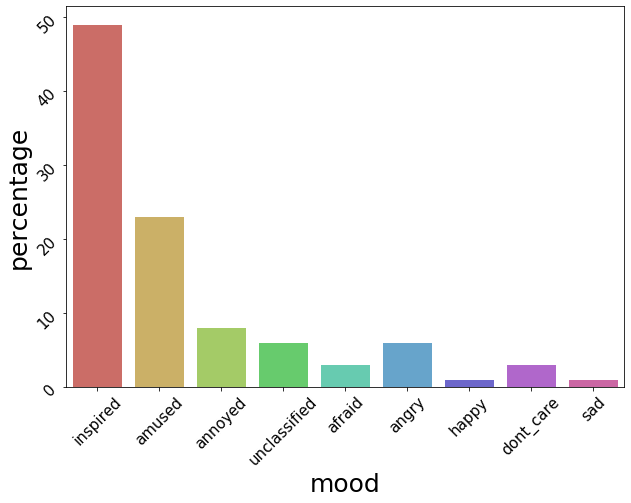

In [88]:
# plot proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plot the scores
plt.figure(figsize=(10,7))
ax = sns.barplot(x='emotion', y='per', data=df, palette="hls")
ax.set_xlabel('mood', fontsize = 25)
ax.set_ylabel('percentage', fontsize = 25)
ax.tick_params(axis="x", labelsize=15, labelrotation=45)
ax.tick_params(axis="y", labelsize=15, labelrotation=45)
plt.show()